## Scatter Matrix

* Мы создадим scatter matrix (матрицу диаграмм рассеяния), чтобы визуализировать взаимосвязь между тремя переменными: средняя разница между первым коммитом и дедлайном, количество посещений страницы и количество коммитов.

#### 1. Подключаемся к базе

In [60]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

conn = sqlite3.connect('../data/checking-logs.sqlite')

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(tables_query, conn)

print(tables)

        name
0  pageviews
1    checker
2  deadlines


#### 2. Загрузка данных

In [61]:
query_commits = """
SELECT uid, labname, timestamp
FROM checker
WHERE uid NOT LIKE 'admin%' AND labname != 'project1'
"""
df_commits = pd.read_sql_query(query_commits, conn)

df_commits.head(5)

,uid,labname,timestamp
0,user_4,laba04,2020-04-17 11:33:17.366400
1,user_4,laba04,2020-04-17 11:40:05.103116
2,user_4,laba04,2020-04-17 11:40:05.237273
3,user_4,laba04,2020-04-17 11:44:20.541374
4,user_4,laba04,2020-04-17 11:44:20.707058


In [62]:
query_views = """
SELECT uid, COUNT(*) as num_views
FROM pageviews
WHERE uid NOT LIKE 'admin%'
GROUP BY uid
"""
df_views = pd.read_sql_query(query_views, conn)

df_views.head(5)

,uid,num_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3


In [63]:
query_deadlines = """
SELECT labs, deadlines
FROM deadlines
"""
df_deadlines = pd.read_sql_query(query_deadlines, conn)

df_deadlines.head(5)

,labs,deadlines
0,laba04,1587945599
1,laba04s,1587945599
2,laba05,1588550399
3,laba06,1590364799
4,laba06s,1590364799


#### 3. Обработка данных

In [64]:
df_commits['timestamp'] = pd.to_datetime(df_commits['timestamp'])

df_merged = pd.merge(df_commits, df_deadlines, left_on='labname', right_on='labs', how='inner')

df_merged['diff'] = (df_merged['timestamp'].astype('int64') // 10**9 - df_merged['deadlines']) / 3600

df_avg_diff = df_merged.groupby('uid')['diff'].mean().reset_index()
df_avg_diff.rename(columns={'diff': 'avg_diff'}, inplace=True)

df_commits_count = df_commits.groupby('uid').size().reset_index(name='num_commits')
df = pd.merge(df_commits_count, df_views, on='uid', how='inner')
df = pd.merge(df, df_avg_diff, on='uid', how='inner')

print(df.head())

       uid  num_commits  num_views    avg_diff
0   user_1           62         28  -58.634372
1  user_10           20         89  -92.766815
2  user_14           61        143 -194.207676
3  user_17           51         47  -48.743527
4  user_18            5          3   -5.381778


#### 4. Потсроение графика scatter matrix

<Figure size 2500x1500 with 0 Axes>

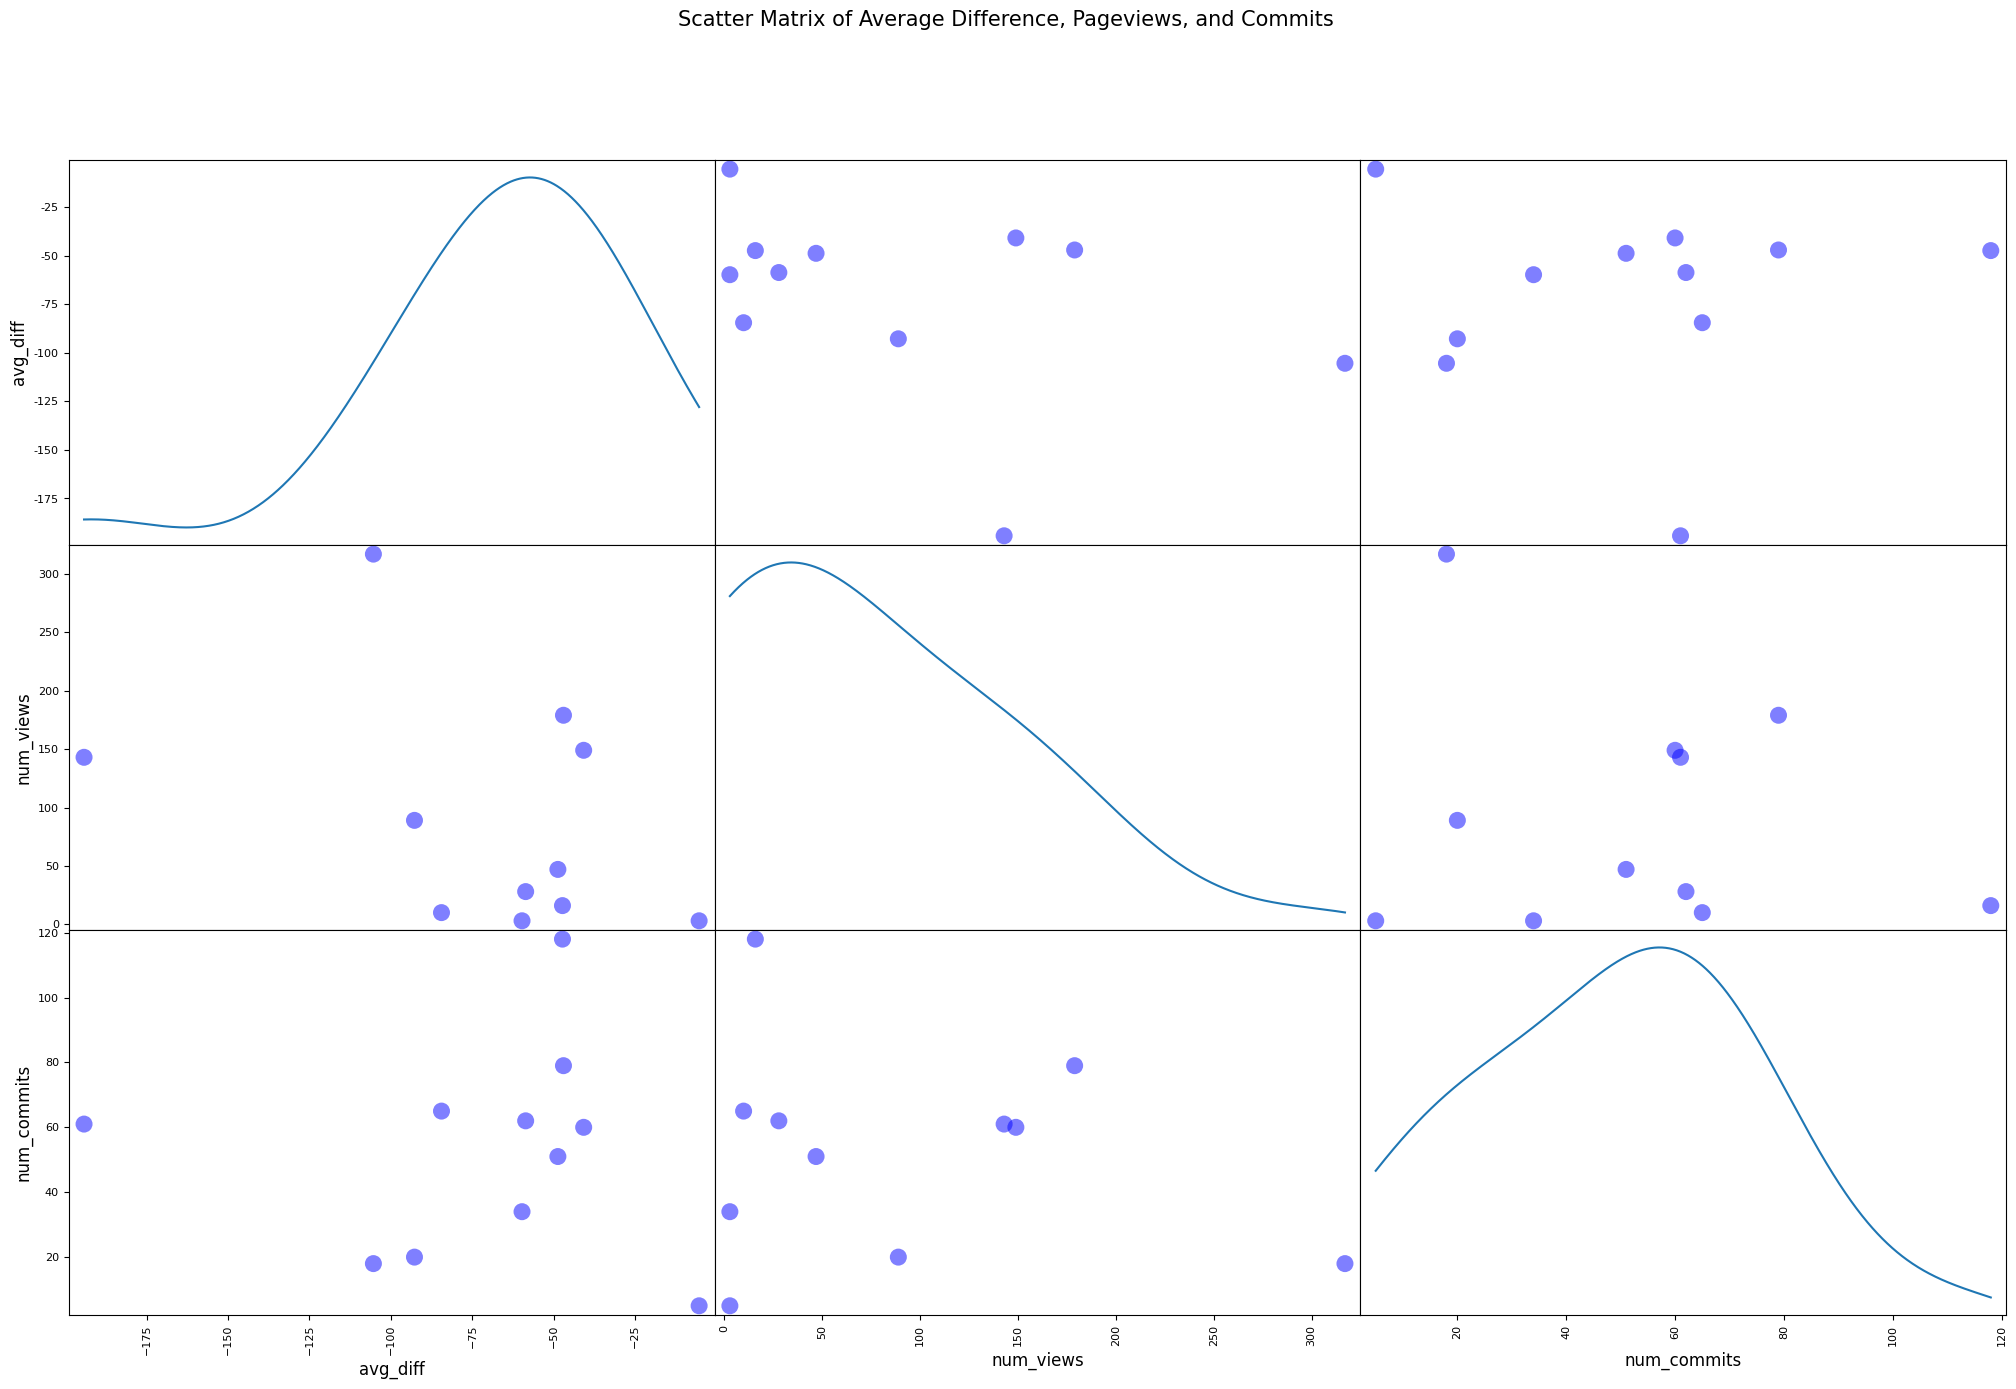

In [70]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(25, 15))

scatter_matrix(
    df[['avg_diff', 'num_views', 'num_commits']],
    figsize=(25, 15),
    diagonal='kde', 
    marker='o',
    s=150,
    linewidths=3,
    color='blue'
)

plt.suptitle('Scatter Matrix of Average Difference, Pageviews, and Commits', fontsize=15)

plt.show()

#### 5. Отвечаем на допы:

* “Can we say that if a user has a low number of pageviews then they likely
have a low number of commits?”

In [68]:
print("1. The answer is: yes.")

1. The answer is: yes.


* “Can we say that if a user has a low number of pageviews then they likely have
a small average difference between the first commit and the lab deadline?”

In [72]:
print("2. The answer is: yes.")

2. The answer is: yes.


* “Can we say that there are many users with a low number of commits and a
few with a high number of commits?”

In [66]:
print("3. The answer is: yes.")

3. The answer is: yes.


* “Can we say that there are many users with a small average difference and a
few with a large average difference?”

In [67]:
print("4. The answer is: yes.")

4. The answer is: yes.
